# Post-quantum Hash Based Cryptography

W tym laboratorium zajmiemy się kryptograrfią postkwantową bazującą na funkcjach skrótu. Wyjaśnijmy sobie więc raz a dobrze o czym dokładnie mowa. Post-quatum nie oznacza, że będziemy teraz pracować na kubitach. Chodzi o algorytmy, które są odporne na ataki z wykorzystaniem komputera kwantowego. Jak wiemy komputer kwantowy ma dużą moc obliczeniową. Chodzi więc o schematy, których złamanie z wykorzystaniem owego komputera jest efektywnie niemożliwe, tzn. czas poświęcony na przeporwadzenie udanego ataku jest bardzo duży. 

Algorytmy postkwantowe bazujące na funkcjach skrótu mają tę zaletę, że ich bezpieczeństwo bazuje wporst na bezpieczeństwie zastosowanej funkcji skrótu. Bezpieczeństwo funkcji skrótu zaś mierzymy z wykorzystaniem bitów bezpieczeństwa. Jeżeli chodzi o szczegółową analizę odsyłam do laboratoriów z SHA-2. Wadą (a może cechą?) tych algorytmów jest to, że umożliwiają one jedynie utworzenie podpisu cyfrowego, a nie wymianę klucza. Z drugiej jednak strony, są stosunkowo proste, co z kolei jest plusem. To im się dzisiaj przyjrzymy.

Główna idea idąca za algorytmami hash-based (HB) jest w większości przypadków taka sama. Podpisujący musi utworzyć pewne losowe wartości przypisane do obiektów, które chce podpisać. Te losowe wartości są haszowane i same skróty są publikowane jako klucze publiczne (znane wszystkim, każdy przypisany do swojego obiektu). W momencie, gdy podpisujący chce podpisać obiekt, musi ujawnić odpowiednią losową wartość, którą dla niego wygenerował i właśnie ta wartość stanowi podpis. Weryfikujący musi zahaszować otrzymany podpis i porównać w ten sposób uzyskany hasz z tym przypisanym do obiektu jako klucz publiczny. Weryfikacja przebiega prawidłowo, gdy obie wartości są takie same.

Algorytmy HB można podzielić na następujące typy:

  1. OTS - z ang. *One-Time Signatures*, czyli takie, gdzie podpis cyfrowy danego obiektu może być użyty tylko jeden raz. Utworzenie kolejnego podpisu wymaga przeprowadzenia ponownie wszystkich kroków algorytmu, włączając w to generowanie kluczy. Jest tak dlatego, iż każdorazowo podpisując obiekt ujawniamy część klucza tajnego. Przykładem algorytmów OTS są podpisy Lamporta czy podpisy Winternitza,

  1. MTS - z ang. *Multi-Time Signatures*, czyli takie, gdzie ten sam obiekt możemy podpisać na kilka sposobów i wysłać bezpieczne kryptograficznie podpisy w kilka miejsc. Sekretem stojącym za MTS jest to, że wykorzystują one wiele niezależnie utworzonych OTS. Kategoria MTS może jednak zostać podzielona na dwie podkategorie:

  stanowe - czyli takie, które muszą kontrolować, które z wygenerowanych OTS zostały już wykorzystane. Jest to starszy typ algorytmów, a jako przykład podać można podać drzewo Merkle (szczegółowo opisane w dalszej części). Ich głównym ograniczeniem jest to, że wszystkie OTS-y muszą być pregenerowane, mamy więc do czynienia z balansem pomiędzy efektywnością, a liczbą możliwych podpisów. Liczba pregenerowanych OTS-ów wprost wpływa na wysokość drzewa, a więc i na rozmiar danych w pamięci, i na ilość danych stanowiących pojedynczy podpis,

  bezstanowe - czyli takie, które nie muszą śledzić wykorzystanych OTS-ów. Ta kategoria tak naprawdę również ma skończoną liczbę OTS-ów do wykorzystania, tylko jest ona bardzo duża (np. rzędu $2^{256}$). Fakt ten pozwala na bezpieczne wybranie losowego z nich i przyzerowe prawdopodobieństwo wykorzystania go ponownie przez bardzo długi czas. W tej rodzinie algorytmów z oczywistych względów OTS-y nie są pregenerowane, tylko generowane na bieżąco. W bezstanowych podpisach MTS potrzebne jest tzw. drzewo certyfikacji. Drzewo certyfikacji pozwala dynamicznie generować niezbędne klucze publiczne, co -- przy założeniu, że klucze prywatne są tworzone w sposób deterministyczny z wykorzystaniem generatora liczb pseudolosowych (czyli znane jest ziarno tego generatora) - pozwala tworzyć ogromną liczbę podpisów bez nadmiernego przeciążania pamięci. 



In [182]:
!pip install pycryptodome
import Crypto.Util.number as cu
import hashlib as hl
import math
from Crypto.Random import get_random_bytes

You should consider upgrading via the 'C:\AGH\Kryptografia\cryptography\crypto\Scripts\python.exe -m pip install --upgrade pip' command.


## Podpis Lamporta (OTS)

Generowanie kluczy:

1. Dla $i = 1,...,n$ wygeneruj dwie losowe wartości: $\left\lbrace sk_{0, i}, sk_{1, i} \right\rbrace$, każda o długości $n$ bitów. W tym przypadku będzie to więc razem $n*2$ różnych wartości $sk$. Wartości $sk$ stanowią klucz prywatny.

2. Dla każdej wartości $sk_{j, i}$, gdzie $j =\left\lbrace 0, 1 \right\rbrace$, a $i = 1,...,n$ oblicz wartość $pk_{j, i} = H(sk_{j, i})$. Wartości $pk_{j, i}$ stanowią klucz publiczny.

Formalnie można napisać, że na końcu algorytmu generowania kluczy otrzymujemy dwa wektory par:
\begin{equation} 
\begin{split}
sk & = [\left\lbrace sk_{0, 1}, sk_{1, 1} \right\rbrace, \left\lbrace sk_{0, 2}, sk_{1, 2} \right\rbrace, ..., \left\lbrace sk_{0, n}, sk_{1, n} \right\rbrace] \\
pk & = [\left\lbrace pk_{0, 1}, sk_{1, 2} \right\rbrace, \left\lbrace pk_{0, 2}, pk_{1, 2} \right\rbrace, ..., \left\lbrace pk_{0, 2}, pk_{1, 2} \right\rbrace],
\end{split}
\end{equation}
gdzie $pk$ jest od początku publiczne dla wszystkich, a całość $sk$ do momentu tworzenia podpisu jest tajna.


In [183]:
n=256
def generate_key():
    sk = [[0]*2 for _ in range(n)]
    pk = [[0]*2 for _ in range(n)]

    for i in range(2):
        for j in range(n):
            sk[j][i] = get_random_bytes(n)
            pk[j][i] = hl.sha256(sk[j][i]).digest()

    print("Private key: sk[0] sk[1]")
    for i in range(n):
        print(f"{i}:\t{sk[i][0]}\t{sk[i][1]}")


    print("Public key: pk[0] pk[1]")
    for i in range(n):
        print(f"{i}:\t{pk[i][0]}\t{pk[i][1]}")

    return sk, pk

sk, pk = generate_key()


Private key: sk[0] sk[1]
0:	b'\xd0\xd8?\xd7xC\xc2=ySe\x94Y\x10E\xa7g\x12\xf3\xfb\x14\xfaF\x88\x0b\xa1V\x0c\xdd\xee\xa0\xf6\xc6\x0b\x9e7\x81N\xe1\x06\xaa\xc7\xee\xb8\x1c\xd7\xe6\xca\x9f\x8b\x85]}e\x8a\x01\x81k\xde\x95\x1fmSz\xad\x17\xa76\xd6f\x0fi\xa3\xae(T\xf3\x90\xdc\xbd{+\xc8l\xa2\xd9f\xf2j\x08\xb3\xf4\xa4\x0baA\x1a?\xbfq\xbc\xf2Qm\xe0\xbeH@\x10\xf6\x1c\xf1B\x16\x0e\xe4\xb9\x14&;\x00S\xb5\xf9\xaa\xb6\x00@\x94\xf0p\xd1\xdb\x10c*\x0bW\x07\xfb\\\\\xd2\xf5!\xa8+E\xaf\xd8\x87{\x97W\xd2\x07\xf8\xdd\x82\xba %\xd6T\x98mi\xa8\xc3\xec*Cu\x82\x05\xbem\xfcR\x02\x0e\xaa\x83\x9a\xd2$\x8e\t\xc9#X\xac^\xaf4\x93\xf5\xd5\x98\xc9\xa3\xf2\xfa\xe5b\xee\x9e\x85\x91\x18\xe33\x88)\xfc\xe3\xc5W\x02D\xc2\np2\xfb\xdc\xc0\xd5SP6\x0f\xcd\xd1\xe9\xb1y%H\x0c\xe4\xb3e\xd1\x93\x9d\xfbG\x06\xbc\x19\xf7\xdf\xe2<\xf9'	b'j:\xb3\x80^\xa8\xbeg\t\xff]\xf6c\n\xae\xb7\t\x1c]v\x98\xfe\xa4B\xe5\xfa^\xe2\xb1\xd2q\t\xcb\xa2\xdfp\xb4\xf6\xf6\xb2\xe4\xa1\xbd4,6\x1f\xd7\xb1\xa2\xe7\xb6\xbb\xfe\x90\xfd\x1d0\\\xb4\x0c\xcf\xd2\xb1\xa5

Generowanie podpisu. Niech $M'$ oznacza wiadomość, którą należy podpisać:

1. Oblicz $M = H(M')$.
2. Niech $M = [b_{n}, b_{n-1}, ..., b_1]$, gdzie $b_i \in \left\lbrace 0, 1 \right\rbrace$. Zapis ten oznacza, że do utworzenia podpisu potrzebne będą bity ($b_i$) otrzymane ze skrótu z wiadomości $M'$.
3. Dla $i = 1,...,n$ podstawiaj $\sigma_{i} = sk_{b_i, i}$. Zapis ten oznacza, że każdy bit skrótu z wiadomości $b_i$ podpisywany jest oddzielnie wartościami losowymi $sk$ generowanymi wcześniej, przy czym jeżeli czytany bit ma wartość $1$, to podpisem tego bitu jest $sk_{1, i}$, a w przeciwnym razie $sk_{0, i}$.
4. Wyślij podpis $\sigma = [\sigma_1, \sigma_2, ..., \sigma_n]$ stronie weryfikującej wraz z wiadomością $M'$.

Weryfikacja podpisu:

1. Oblicz $M = H(M')$.
2. Niech $M = [b_{n}, b_{n-1}, ..., b_1]$, gdzie $b_i \in \left\lbrace 0, 1 \right\rbrace$.
3. Dla $i = 1,...,n$ sprawdzaj, czy $H(\sigma_{i}) = pk_{b_i, i}$. Jeżeli w którymkolwiek momemcie równość nie zachodzi, weryfikacja nie powiodła się. W przeciwnym razie, weryfikacja przebiegła pomyślnie.

Schemat ten oferuje $\frac{n}{2}$ bitów bezpieczeństwa, gdzie $n$ oznacza liczbę bitów skrótu zwracanego przez H.

In [184]:
def lamport_sign(message, secret_key):
    hash_message = hl.sha256(message).digest()
    signature = []

    for i in range(n):
        for j in range(8):
            bit = hash_message[j] >> 7  #hash_message[i] pierwsza czesc wiadomosci, >> 7najbardziej znaczacy bajt
            signature.append(secret_key[j][bit])
    return signature

message = b"Hello, world!"
signature = lamport_sign(message, sk)

print("Signature:")
for i in range(n):
    print(f"{i}:\t{signature[i]}") #odzwierciedla klucze prywatne

Signature:
0:	b'\xd0\xd8?\xd7xC\xc2=ySe\x94Y\x10E\xa7g\x12\xf3\xfb\x14\xfaF\x88\x0b\xa1V\x0c\xdd\xee\xa0\xf6\xc6\x0b\x9e7\x81N\xe1\x06\xaa\xc7\xee\xb8\x1c\xd7\xe6\xca\x9f\x8b\x85]}e\x8a\x01\x81k\xde\x95\x1fmSz\xad\x17\xa76\xd6f\x0fi\xa3\xae(T\xf3\x90\xdc\xbd{+\xc8l\xa2\xd9f\xf2j\x08\xb3\xf4\xa4\x0baA\x1a?\xbfq\xbc\xf2Qm\xe0\xbeH@\x10\xf6\x1c\xf1B\x16\x0e\xe4\xb9\x14&;\x00S\xb5\xf9\xaa\xb6\x00@\x94\xf0p\xd1\xdb\x10c*\x0bW\x07\xfb\\\\\xd2\xf5!\xa8+E\xaf\xd8\x87{\x97W\xd2\x07\xf8\xdd\x82\xba %\xd6T\x98mi\xa8\xc3\xec*Cu\x82\x05\xbem\xfcR\x02\x0e\xaa\x83\x9a\xd2$\x8e\t\xc9#X\xac^\xaf4\x93\xf5\xd5\x98\xc9\xa3\xf2\xfa\xe5b\xee\x9e\x85\x91\x18\xe33\x88)\xfc\xe3\xc5W\x02D\xc2\np2\xfb\xdc\xc0\xd5SP6\x0f\xcd\xd1\xe9\xb1y%H\x0c\xe4\xb3e\xd1\x93\x9d\xfbG\x06\xbc\x19\xf7\xdf\xe2<\xf9'
1:	b"P\x8e\xf00\x84bbE\xc3%\xca6\xe7$\nG\xd5\xcd0\xd4\x8f\x7f\x98:h\x9d^\xf3\x0f\xa7\xac\xe0`u\xf7\xc6n\xba\x08H\x0c4\x06\x86\x98\xb8\x9aw\xa1\xbc\xa1\xba\xfc\x91\xff\xfa\xcf\x9fb@3,\x06\x89\x05\xb7\xb7oIb\xcfG\x8e\xc4

In [185]:
def lamport_verify(sig, message, public_key) :
    hash_message = hl.sha256(message).digest()
    verif_message = []

    for i in range(n) :
        for j in range(8):
            bit = hash_message[j] >> 7
            if hl.sha256(sig[j]).digest() != public_key[j][bit] :
                raise ValueError("Verification failed")
            verif_message.append(public_key[j][bit])
    print("Verifcation successful")
    return verif_message

verification = lamport_verify(signature, message, pk)


print("Verification:")
for i in range(n):
    print(f"{i}:\t{verification[i]}") #odzwierciedla klucze publiczne

Verifcation successful
Verification:
0:	b'\xd0\xed\xc3\xf9\xdc\xcc\xb1\xef\xd4\xe8\xb8\xb9\x9c\x11i\xef|1\xa2\x81\x98\x1e@\xc2r\x93*\xda!\xdeq\xf5'
1:	b'\xf3\xed\xba\x04N\xf4a\xfe\xb2\xfe\xe3\xb6\x91\x1b_o\x96uj\x94\x1c\x05\x89\x87\x02\xa4\x85\x004_\xcfm'
2:	b"\xea\x19\x83 up^0\x1f\xc0~\xdb\x88'\xc4\xde\xb8\xd1U\xa7\xee\x01P\xc5\xc5\xac\xe8\xaa\xd3k\x1a?"
3:	b"Mr\xe6\xaa\xa9y\xd2\xe5\x12c3\xaf\x11\x08\xa7Xo\x1e\xbfc4\xe5\x15;';\xb6:\x1e,\x08\x01"
4:	b"\xc7\x90\xd4]\x14\x94\xbc\x10\xd0\x8e\xa7}\xaf\xc6\x89\x0cj'\xdc\x8dj\x17b\xb9\xa4\xfb\x1aS\xce\xc3\x955"
5:	b'\xbcr\x7f\x1bJk\xa7)\xba~+\x88.\x80\xfas9\x80/\xd2R\xf3\xc0\x14\xff\t\x93\xa0\xbcO\x1b\xce'
6:	b'\x17\r`\xa3Q\xae\xb9\t\xa3\xce\x9cigx2\x92\\\xc9\xce\xfej\xef\xe4\x845S\xb7\x99\xaeQe\xdd'
7:	b'\t\xd1R}+\xae\xa6\xb3\x91E\xab\xa2D\r>ivu\x12G\xb3\xb4\x14\xfd)\x05\xb6\x1b\x97\xd0\xb8M'
8:	b'\xd0\xed\xc3\xf9\xdc\xcc\xb1\xef\xd4\xe8\xb8\xb9\x9c\x11i\xef|1\xa2\x81\x98\x1e@\xc2r\x93*\xda!\xdeq\xf5'
9:	b'\xf3\xed\xba\x04N\xf4a\xfe\xb2\xfe

## Podpis Winternitza (OTS)

Podpis Wintertza, czyli WOTS (z ang. *Winternitz One Time Signature*), posiada dodatkowy parametr $w$, który musi ustalić użytkownik. Wartość $w$ decyduje o liczbie bloków, na które będzie dzielony skrót $M$ z wiadomości $M'$ i powinna być ona potęgą czwórki (ze względów implementacyjnych). Większe wartości $w$ skutkują mniejszymi rozmiarami podpisu, ale i dłuższym czasem jego tworzenia.

Posiadając długość skrótu w bitach $n$ oraz wybraną wartość $w$ należy policzyć następujące wartości:

\begin{align}
    l_1 &= \left\lceil \frac{n}{log_2(w)} \right\rceil \\
    l_2 &= \left\lfloor \frac{log_2(l_1*(w - 1))}{log_2(w)} \right\rfloor + 1 \\
    L &= l_1 + l_2 
\end{align}

Wartość $l_1$ określa liczbę bloków utworzonych ze skrótu z wiadomości. Każdy taki blok składa się dokładnie z $log_2(w)$ bitów, które później są interpretowane jako liczby z zakresu $[0, w-1]$. Wartość $l_2$ określa minimalną liczbę bloków, na której można zapisać sumę kontrolną z tworzonej wiadomości. Są to również bloki $log_2(w)$ bitowe interpretowane jako liczby z przedziału $[0, w-1]$. Wartość $L$ określa długość całego podpisu.

Generowanie kluczy:

1. Dla $i = 1,...,L$ generuj losowe, $n$-bitowe wartości $sk_i$. Wynik tej operacji można zaprezentować w postaci wektora $sk = [sk_1, sk_2, ..., sk_L]$, który stanowi klucz prywatny.

2. Dla $i = 1,...,L$ obliczaj wartości $pk_i = H^{(w - 1)}(sk_i)$, gdzie $H^{(w - 1)}$ oznacza, że wykonujemy $w - 1$ haszowań, a wejściem każdego kolejnego jest wyjście poprzedniego. Przykładowo: $H^4(x) = H(H(H(H(x))))$. Obliczone wartości mogą zostać przedstawione w formie wektora $pk = [pk_1, pk_2, ..., pk_L]$, który stanowi klucz publiczny znany obu stronom komunikacji.

In [186]:
w = 16
l1 = math.ceil(n/math.log2(w))
l2 = math.floor(math.log2(l1 * (w - 1))/math.log2(w)) + 1
L = l1 + l2

In [187]:
w = 16
l1 = math.ceil(n/math.log2(w))
l2 = math.floor(math.log2(l1 * (w - 1))/math.log2(w)) + 1
L = l1 + l2

def generate_key_wint(L):
    sk = []
    pk = []

    for i in range(L):
        sk_i = get_random_bytes(n)
        sk.append(sk_i)

        pk_i = sk_i
        for _ in range(w - 1):
            pk_i = hl.sha256(pk_i).digest()
        pk.append(pk_i)

    return sk, pk

sk, pk = generate_key_wint(L)

In [188]:
sk

[b':ITh\xd3\xaa\x9d\x1b\xa4\x0eU\xbd\'H\xf9\xe3n\xb1\x16\xdcN\xdb\x93:\x0e\xbcY\x1cV\xf1\xb1\xbdg-\x99\r\xb7Q\xbb{\x9f\x91}QPq4\x89\xae\xdd\x88\xcb\xc1#\xe3\x95O\x8d\xe8\xa0\x81\x8b\x81\x97\xa1>\xc8`\x9c/\x06\xd8|\xd0.v\x95Z\x7f \x03w\xddA\xf0\xb9\xdb"\x1dwC\x89z\xd18Q&\xc8\xb8\x85lAb\xc7\xd9A\x07\x91v\x1b\xa5\xef\x0e\xe6n\x84B\x00\x98\xbdb\xc2\xff\xbcz\x82\xb9<\x91\xaa=\x11y\xb2\x86\x9c\xb4bs\xf7\xca\x98<\x93M\x0e\x00\x9c]$\x07\x08\xa5<Y\x17m\xb2.\xad\xb1\n\x9a>7u\xf6]\x00Q\xbf\xea\xba]\xb8\xf7\x17@NU;Gw\xc0\x85n\x1e\xae0\xcb(\xdf\x1b\xe6\x1f(Q\xc3U\x14\x9f&rb\x9b\xb8\x83\x8d\x0eFP\xbe\xdb,\x89\xc4\xd9\xd3\xab\xe6W4\xc4\x9e#io<jt\xa9\x15$H\x19\x99\x84~$\x1f3\xd9P\xb4}~\x0bl\xde\xdd1E\xbe\x85\x1c\x16',
 b"\xfc%\xaf\xb4\xed@Z$\x1b\xf6\xea\x81P\xf2\x99=\xcc\x96\xb5-\xb7e6V\xe0\xdb\xa0\xc6\x06x\xea\x8a\x0c\xe2\x92\x11\xa9\x9e\xfe\xbd'\x91\x8e\x7fv`\x98\xbbN!\x14BR\xef\xbf\xbd\x111\xbcxG*\xe0Z\xb8\xd1\x9du0\xcf\x81\xa5\xf5%\x11\xdb\xc7}\x87o\xea y\x84g\xb2\x86\x08\x16\x1b\x08l.0\xa6\xcco=\

In [189]:
L

67

In [190]:
len(sk)

67

Tworzenie podpisu:

1. Oblicz skrót $M'' = H(M')$, gdzie $M'$ jest wiadomością podpisywaną.
2. Podziel skrót $M''$ na $l_1$ słów binarnych, każde o długości $log_2(w)$. Przekonwertuj każde z otrzymanych słów binarnych na liczby. Wynikiem operacji powinien być wektor $M = [M_1, M_2, ..., M_{l_1}]$, gdzie $M_i$ jest liczbą z przedziału $[0, w - 1]$.
3. Oblicz sumę kontrolną jako $CS' = \sum_{i=1}^{l_1} w - 1 - M_i$. Następnie podziel sumę kontrolną na $l_2$ słów binarnych (każde o długości $log_2(w)$) i przekonwertuj te słowa na liczby. Wynikiem operacji powinien być wektor $CS = [cs_1, cs_2, ..., cs_{l_2}]$, gdzie $cs_i$ jest liczbą z przedziału $[0, w - 1]$.
4. Dołącz bloki sumy kontrolnej do bloków wiadomości $M$. Wynikiem działania powinien być wektor: $M = [M_1, M_2, ..., M_{l_1}, CS_1, CS_2, ..., CS_{l_2}]$. Ponieważ suma kontrolna musi być podpisana razem z wiadomością, a $l_1 + l_2 = L$, dla uproszczenia nowy wektor wiadomości zostanie oznaczony jako $M = [M_1, M_2, ..., M_L]$.
5. Sygnaturę wiadomości stanowi wektor $\sigma = [\sigma_1, \sigma_2, ..., \sigma_L]$, gdzie $\sigma_i = H^{M_i}(sk_i)$. Wyślij sygnaturę wraz z wiadomością $M'$ stronie weryfikującej.

Weryfikacja podpisu:

1. Wykonaj kroki 1 - 4 z algorytmu tworzenia podpisu opisanego powyżej.
2. Oblicz elementy wektora $p = [p_1, p_2, ..., p_L]$, gdzie $p_i = H^{w - 1 - M_i}(\sigma_i)$.
3. Dla $i = 1, ..., L$ wykonaj porównania $p_i = pk_i$. Jeżeli w którymkolwiek momencie równość nie zachodzi, weryfikacja nie powiodła się. W przeciwnym przypadku weryfikacja powiodła się.

Schemat ten oferuje $\frac{n}{2}$ bitów bezpieczeństwa, gdzie $n$ oznacza liczbę bitów skrótu zwracanego przez H.

In [191]:
def winternitz_sign(message, secret_key):
    hash_message = hl.sha256(message).digest()
    
    log2_w = math.log2(w)
    M = []
    for i in range(l1):
        for j in range(8):
            act_word_start = int(j * log2_w)
            act_word_end = int((j+1) * log2_w)
            binary_word = hash_message[act_word_start:act_word_end]
            decimal_value = int.from_bytes(binary_word, 'big') % w
            M.append(decimal_value)

    CS_prime = (w - 1) * l1 - sum(M)

    CS = []
    for i in range(l2):
        binary_word = CS_prime % w
        CS_prime //= w
        CS.append(binary_word)

    M.extend(CS)

    signature = []
    for i in range(L):
        hashed_value = secret_key[i]
        for _ in range(M[i]):
            hashed_value = hl.sha256(hashed_value).digest()
        signature.append(hashed_value)
    return signature

message = b"Hello, world!"
signature = winternitz_sign(message, sk)

print("Signature:")
for i in range(L):
    print(f"{i}: {signature[i]}")


Signature:
0: b'\xda\x85b\x89-H{UL\xda\x10\x11\x9a\x8e\xc6\xee\x13\xe8\xa0X\x97\xdb/\xcf\xd5\xce\x8f\x94\xa4\xf9\xb6\xaa'
1: b'\x006\x9a\x145\x9cW\xcf\x15\xb6%@\x04Z\xf9\xe6\xa0\xb7L\x16*\xcb\xb5GK\x9a\xf2\x87\xe6\x99\x9c\xad'
2: b'C%E\xc6nO\xd8\xa7\t\xd9\xb5\xad@\xa6\xf1\xf4\r:\xab\xcd\xceNq\\TdN\xf2\xb2|*\xe8'
3: b']\xdc\xf5\xe7\xff\xd1\xbb\xf8\xd3c\xa8\xae\xbf_\xd8\r\xc1!\xbao\xdc\x13BG\xf6\xbfi\xd8\xeap\x1f\xcb'
4: b'6\xaf\xe3\x9b\xca\x8b\xd6Oj\xd6[z|\xa1{\xf2\x96\x13s\x95\x9f\x8dD\x91\x0f3\xc2\xe1)\x88\x19\x0b'
5: b'E\x96sw+*D\xbb\xe2\xdc]\x97CX\xbf\xaft>r\xea\xee.c\x1cL\x0eh\xf9{\xf8\x05`'
6: b'.\xecI\x97\xe6\xff\xfd\xf2\xd6K(\xbc\xe3%\xe2\xee\xaf\x88\xda\xee\x1d\xffw\xf8\xc7\xe2\xeb\xc9a\xe2x\xe3'
7: b'{A\x95\xfd\r\\\xc0\x01\xae\xeb\xab\xfb7\xe6N\xf4:\x89)\xf3\x81I85\xcf\xffa\xaa\xfe"\xa9n'
8: b'\xd9a\xc9\xcd\xfdx_\r\x8eA\xe6B\xad\x9f\xc5?\xec\xb0\x17\x8bs\x10s3\x07\x1dc\x81s\xca\x99\xad'
9: b'\t0\xcaT\xb6;a\x1af\x00\x1d)[\xf3\xc5\xe4]\xf4D\x0bbs\xaa\x94\xe6."\xc6\xaa\xb15\xff'


In [192]:
signature

[b'\xda\x85b\x89-H{UL\xda\x10\x11\x9a\x8e\xc6\xee\x13\xe8\xa0X\x97\xdb/\xcf\xd5\xce\x8f\x94\xa4\xf9\xb6\xaa',
 b'\x006\x9a\x145\x9cW\xcf\x15\xb6%@\x04Z\xf9\xe6\xa0\xb7L\x16*\xcb\xb5GK\x9a\xf2\x87\xe6\x99\x9c\xad',
 b'C%E\xc6nO\xd8\xa7\t\xd9\xb5\xad@\xa6\xf1\xf4\r:\xab\xcd\xceNq\\TdN\xf2\xb2|*\xe8',
 b']\xdc\xf5\xe7\xff\xd1\xbb\xf8\xd3c\xa8\xae\xbf_\xd8\r\xc1!\xbao\xdc\x13BG\xf6\xbfi\xd8\xeap\x1f\xcb',
 b'6\xaf\xe3\x9b\xca\x8b\xd6Oj\xd6[z|\xa1{\xf2\x96\x13s\x95\x9f\x8dD\x91\x0f3\xc2\xe1)\x88\x19\x0b',
 b'E\x96sw+*D\xbb\xe2\xdc]\x97CX\xbf\xaft>r\xea\xee.c\x1cL\x0eh\xf9{\xf8\x05`',
 b'.\xecI\x97\xe6\xff\xfd\xf2\xd6K(\xbc\xe3%\xe2\xee\xaf\x88\xda\xee\x1d\xffw\xf8\xc7\xe2\xeb\xc9a\xe2x\xe3',
 b'{A\x95\xfd\r\\\xc0\x01\xae\xeb\xab\xfb7\xe6N\xf4:\x89)\xf3\x81I85\xcf\xffa\xaa\xfe"\xa9n',
 b'\xd9a\xc9\xcd\xfdx_\r\x8eA\xe6B\xad\x9f\xc5?\xec\xb0\x17\x8bs\x10s3\x07\x1dc\x81s\xca\x99\xad',
 b'\t0\xcaT\xb6;a\x1af\x00\x1d)[\xf3\xc5\xe4]\xf4D\x0bbs\xaa\x94\xe6."\xc6\xaa\xb15\xff',
 b'\xdac\x8f\x14\xdd\

In [193]:
len(signature)

67

In [194]:
def winternitz_verify(signature, message, public_key, type_of_alg):
    hash_message = hl.sha256(message).digest()
    log2_w = math.log2(w)
    M = []
    for i in range(l1):
         for j in range(8):
            act_word_start = int(j * log2_w)
            act_word_end = int((j+1) * log2_w)
            binary_word = hash_message[act_word_start:act_word_end]
            decimal_value = int.from_bytes(binary_word, 'big') % w
            M.append(decimal_value)

    CS_prime = (w - 1) * l1 - sum(M)

    CS = []
    for i in range(l2):
        binary_word = CS_prime % w
        CS_prime //= w
        CS.append(binary_word)

    M.extend(CS)

    p = []
    for i in range(L):
        hashed_value = signature[i]
        for _ in range(w - 1 - M[i]):
            hashed_value = hl.sha256(hashed_value).digest()
        p.append(hashed_value)

    if type_of_alg == 'Verification of public key' :

        for i in range(L):
            if p[i] != public_key[i]:
                raise ValueError("Verification failed")
        return p
    elif type_of_alg == 'Retrive public key' :
        return p

winternitz_verify(signature, message, pk, "Verification of public key")
print("Verification successful")



Verification successful


## Drzewo Merkle (MTS)

Drzewo Merkle jest idealnym drzewem binarnym, którego liście stanowią podpisy WOTS, węzły mają wartość skrótu obliczonego ze swoich dzieci ($||$ oznacza konkatenację), a węzeł główny (z ang. *root noode*) stanowi klucz publiczny. Drzewo o wysokości $h$ zawiera $2^h$ węzłów będących liśćmi (podpisy WOTS).

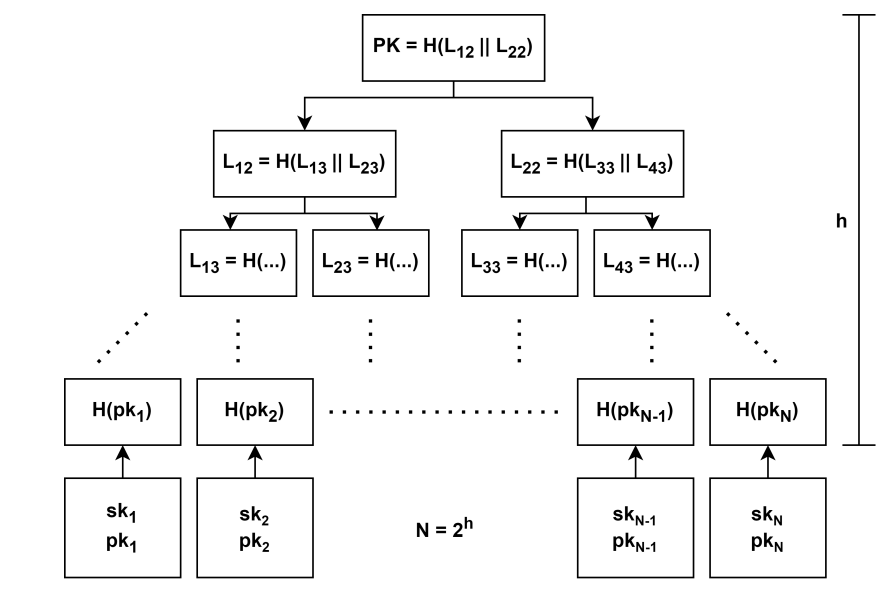

Główną zaletą tego schematu jest to, że jest jeden klucz publiczny, który może być użyty wielokrotnie i jest rozmiaru $n$, gdzie $n$ to długość skrótu zwracana przez funkcję skrótu $H$. Podpisujący wykorzystuje standardowo schemat WOTS do utworzenia podpisu z wiadomości $M'$, ale upublicznia weryfikującemu sam podpis $\sigma$, klucz publiczny $PK$ oraz tzw. ścieżkę autentykacji. Nie upublicznia natomiast klucza publicznego WOTS $pk$, którego rozmiary są znacznie większe niż $PK$. Ścieżka autentykacji to skróty z węzłów pośrednich, które mają umożliwić weryfikującemu odtworzenie klucza głównego $PK$. Przykładowa ścieżka autentykacji została zaprezentowana na rysunku poniżej, gdzie dla niewielkiego drzewa podpisujący wybrał pierwszą parę kluczy WOTS (wierzchołek oznaczony na zielono), a do utworzonego podpisu musi dołączyć wszystkie skróty oznaczone na pomarańczowo. Warto dodać, że udostępnianie weryfikującemu liścia oznaczonego na zielono jest niepotrzebne, gdyż wartość $pk_1$ weryfikujący obliczy sam z otrzymanego podpisu $\sigma_1$ (zgodnie z algorytmem WOTS). 

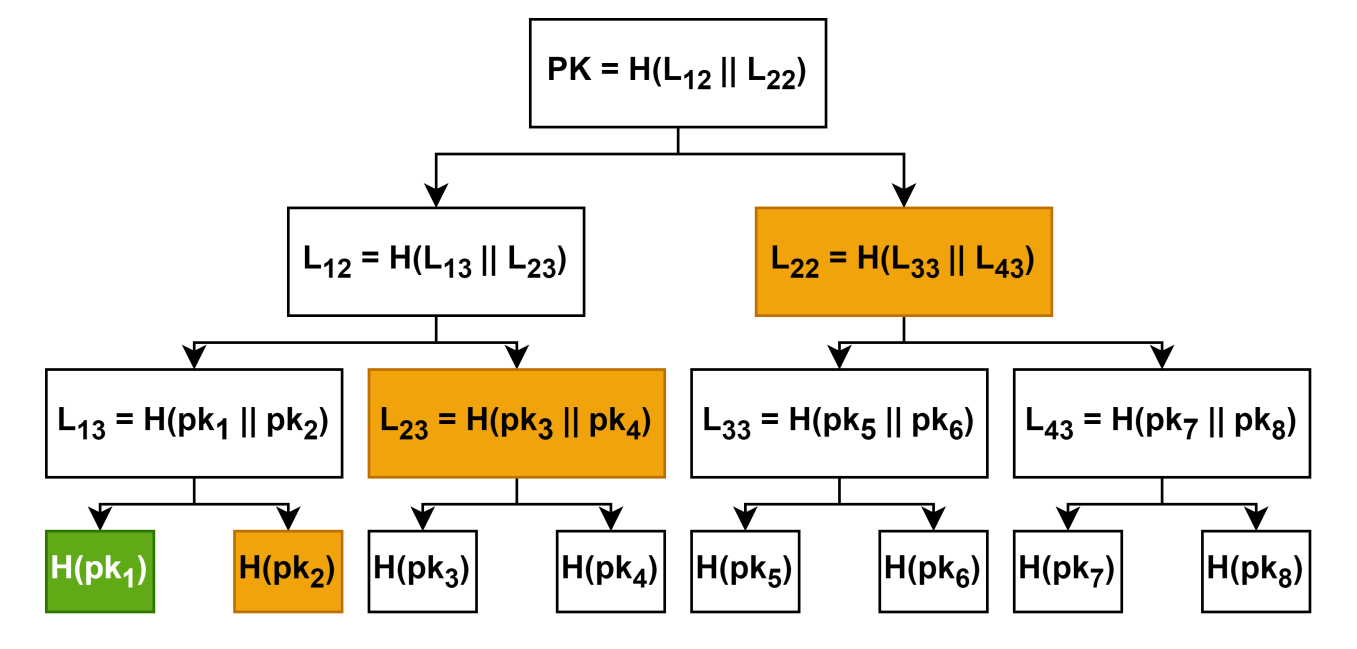

Generowanie kluczy:

1. Wygeneruj klucze dla schematów WOTS $(sk_i, pk_i)$ dla $i = 0,..., 2^h - 1$.
2. Oblicz liście Drzewa Merkle: $node_{(2^h + i)} = H(pk_i)$, dla $i = 0,..., 2^h - 1$.
3. Oblicz pozostałe węzły Drzewa Merkle (te niebędące liśćmi): $node_i = H(node_{2i} || node_{2i + 1})$. Kluczem głównym $PK$ jest węzeł o indeksie 0, czyli $node_0$.

In [195]:
def concatenate_bytes(byte_list):
    concatenated_bytes = b''.join(byte_list)
    return concatenated_bytes

def generate_merkle_tree_keys(h):
    num_leaves = 2 ** h
    merkle_tree = [b""] * (2**(h+1) - 1) # np dla h=4 musze miec 31 miejsc razem z PK bo 16+8+4+2+1=31=2*5-1

    sk = []
    pk = []
    for i in range(num_leaves):
        sk_i, pk_i = generate_key_wint(L)
        sk.append(sk_i)
        pk.append(pk_i)
        pk_i = concatenate_bytes(pk_i)#pk z danego liscia
        hash_pk_i = hl.sha256(pk_i).digest()
        # print(-2**h+i)
        merkle_tree[-2**h+i] = hash_pk_i #wypelniam ostatnie 16 miejsc
        # print(merkle_tree)

    position = 2**h
    for level in range(h-1, -1, -1): # 3,2,1,0 --> kolejny wyższy poziom
        #na danym poziomie wypelniam drzewo
        for i in range(2**level) : # czyli np na poziomie 3 musze przesunac sie w drzewie o odpowiednia ilosc miejsc tzn od tylu wypelnic 8 miejsc (-16+8)
            pos = -(position+2**level)+i # np -16-2**3+i na poziomie 3
            left_child_pos = -position+2*i
            right_child_pos = -position+2*i+1
            # print(left_child_pos)
            # print(pos)
            # print(right_child_pos)
            merkle_tree[pos] = hl.sha256(merkle_tree[left_child_pos]+merkle_tree[right_child_pos]).digest()
        position = position + 2**level 
        # print(position)
    main_public_key = merkle_tree[0]
    return sk, pk, main_public_key, merkle_tree

sk, pk, main_public_key, tree = generate_merkle_tree_keys(4)

In [196]:
def get_length(object) :
    return f"Lengtht: {len(object)}"

In [197]:
get_length(sk)

'Lengtht: 16'

In [198]:
get_length(pk)

'Lengtht: 16'

In [199]:
get_length(tree)

'Lengtht: 31'

Generowanie podpisu:

1. Oblicz skrót $M'$ z wiadomości $M$: $M' = H(M)$.
2. Wybierz parę kluczy WOTS $(sk_i, pk_i)$, które zostaną użyte do stworzenia podpisu wiadomości. Podpisujący musi wiedzieć, które pary już wykorzystał i wziąć kolejną, która nie była jeszcze użyta. Wartość $i$ jest określana mianem ,,stanu''.
3. Utwórz podpis WOTS: $\sigma$ i dostarcz podpis wraz ze ścieżką autentykacji do strony weryfikującej. Ścieżkę autentykacji stanowią odpowiednie węzły drzewa Merkle.

In [200]:
def get_index(idx) :
    return (idx+1, "right") if  idx % 2 == 0 else (idx-1,"left")

def generate_signature(message, sk, pk, merkle_tree, i, h):

    sks, pks = sk[i], pk[i]
    signature = winternitz_sign(message, sks)

    index, p = get_index(i)
    position = 2**h # dla h=4 --> 16
    
    auth_path = [(merkle_tree[-position+index], p)]
    

    for level in range(h-1, 0, -1) : # do wyzszych poziomów bez poziomu root
        position = position + 2**level # dla level=3 --> 8 czyli 16+8=24
        idx_parent = index // 2
        idx_parent_next, p = get_index(idx_parent) # strona szukanego sasiada
        auth_path.append((merkle_tree[-position+idx_parent_next], p))
        index = idx_parent_next

    return signature, auth_path

message = b"Hello, world!"
i = 4
signature, auth_path = generate_signature(message, sk,pk, tree, i, 4)

print("Signature:", signature)
print("Authentication path:", auth_path)


Signature: [b'"G\xad\xedA\x93\xf0\xdb\xd9etu|\xa4n\x8c!\xb6\xee\xe2\x06\xf9uI\'\xb5I\\\xa2\x1b.\xfe', b'2\xca\xbcQ\x11\x86\x87\x1a\xb5\x9d>\xb7\xd7Z^\xc0O\xf5T\xdaD\x1c\xb5\x08\xc9\xc9\xc7\x16\xfd\xeb\xf2a', b'f\xde\x89\xaa]\xf6\xdf\xe4\x97\xb7\xaa\xaa\xac\xe7r]J!\xf9\xf8\xa9*\xe4e\xf1n\xab\xbb\xcd\x08\xe6h', b'\xac\x80\xc8\xe2\xac\xbcG\x87X\x85\xe3I\xbaB3&\xc8/S\x9b,\x9e\xfb$\t5\x87\x00\xba\xb6R\xb6', b'*\xc1B\xb1\xbao\x01F\xc0\x0e\xbc}R\xf2^\xeb\x07U\xb10?\x8c\xe8*\x95\xa5\xeb\xaa\x17%]\xd5', b'FF&\xf1\x1c\x85[P\x12\xf4<\x9b\x96\x86\xb9\xf84[\xb3\xabh\x00\xb4\xb7_W\xa5\xfb\xe3.\xc8\xdf', b'\x03B7W\xc1\xb5\xb4\xaf:\x80\xff\x03\xa9\xfb\xf1\xf6d\x91c\xbcK\xda\x8a\xfd_\x07q\xc5\x81\x84\x0b\x15', b'\xb6C\xeb_[/\xcd\xc4\xd5hu\x08w\xd4\x9dr\xafR\x01\xeb\x82VR\xb4\xa0\xbf\x15\xca\xd0]L\xe1', b'\x02gZ\x86\xe6\xd9\xec\xe5\xf4\xdd\xce\xb9\x18\xdf\xdd\x8dT\xbeHNlwx\xd0\x02Z\x19\xc02\x14\x92\xfe', b'\xbe\xa1\xb8[(\x84\xe2\xc0\xbe0&\xf8HC\xbd\xaa=?U!\xd1/`\xaf\xf5\xcd8@\xf9\x15\xf1\x82', b'\xf5\xc

In [201]:
len(signature)

67

In [202]:
len(auth_path)

4

Weryfikacja podpisu:

1. Oblicz skrót $M'$ z wiadomości $M$: $M' = H(M)$.
2. Wykorzystując algorytm WOTS przywróć wartość $pk_i$ z otrzymanego podpisu $\sigma_i$.
3. Oblicz skrót z $pk_i$ i wykorzystując ścieżkę autentykacji odtwórz wartość $PK$ (czyli węzła $node_0$).
4. Jeżeli odtworzona wartość $PK$ jest taka sama co udostępniona przez stronę tworzącą podpis -- weryfikacja powiodła się. W przeciwnym razie została zakończona niepowodzeniem.

In [203]:
auth_path

[(b"3'-Y\x0e\x9dk\xfa\xc4\xb7\x8b\xcd\x19='CV\xf7\x9b\xf5\xb3)\x9a\xa8\x0c\xf9\xcdx\xfb\xa2Yd",
  'right'),
 (b't\x91\xff\x88\xe8KMm\xe8\x9f\x8ew\x9c\xbc\xbd\xa4I\xb9`\x9b\xb2\xad$\xdf\x02$,\x13m\xbe\x1b\x91',
  'right'),
 (b'\x8a\x19\x9b\xc2\xe4\r\xf3\xed\xf2\xb6\x0fe\xd7B\xd0\xf2\x1dlv\x94\x15\x8dY\xfb\xb3\x16\x05T\xb6P\x81\xf2',
  'left'),
 (b'}\xbfb\x13f\xd7B\xeeP\x12%\xdd8\xb6G\x14\x02\x11F\x94\x18\x18\x10\xe4\x02q\xdc)\x95|\xd7V',
  'right')]

In [204]:
def verify_signature(message, signature, auth_path, main_public_key):

    reconstructed_pk = winternitz_verify(signature, message, None, type_of_alg="Retrive public key")
    reconstructed_pk = hl.sha256(concatenate_bytes(reconstructed_pk)).digest() #pk z liscia 
    PK = reconstructed_pk
    #majac sciezke szukamy PK z root'a
    for sibling, s in auth_path:
        if s == "left":
            PK = hl.sha256(sibling + PK).digest()
        else:
            PK = hl.sha256(PK + sibling).digest()
              
    if PK == main_public_key:
        return True
    else:
        return False

verification_result = verify_signature(message, signature, auth_path, main_public_key)

if verification_result:
    print("Successful verification")
else:
    print("Verification failed")


Successful verification


## HORS (FTS)

Algorytm HORS (*Hash to Obtain Random Subset*) należy do kategorii tzw. algorytmów FTS, czyli *Few Times Signatures*. Tak naprawdę FTS-y nie są do końca ani OTS-ami, ani MTS-ami, ciężko je więc zaklasyfikować. Teoretycznie wygenerowanego zestawu danych można użyć więcej niż raz. W praktyce jednak, każde kolejne użycie tego samego zestawu zmniejsza sukcesywnie jego bezpieczeństwo. 

Algorytm HORS nie jest uznawany za bezpieczny. W szczególności jest podatny na tzw. *subset-resilent problem* lub inaczej mówiąc *Weak Messages Attack*. Niemniej jest to algorytm istotny, gdyż stanowi on swoistą bazę dla algorytmu FORS, który jest wykorzystywany w SPHINCS+.
Niech $k\tau$ oznacza długość skrótu zwracaną przez funkcję skrótu $H$. Parametry $k\tau$ dobierane są tak, że skrót z wiadomości $m$ równy $H(m)$ można podzielić na $k$ równych bloków bitów, każdy w reprezentacji liczbowej z przedziału $t = 0,...,t-1$, gdzie $t = 2^{\tau}$. Wartość $t$ zawsze musi być potęgą dwójki.

Generowanie kluczy:

1. Wygeneruj $t$ losowych wartości stanowiących klucz prywatny: 

\begin{equation}
    sk = [sk_1, sk_2, ..., sk_t],
\end{equation}

2. Oblicz klucz publiczny PK:

 \begin{equation}
     PK = [pk_1, pk_2, pk_t] = [H(sk_1), H(sk_2),..., H(sk_t)].
 \end{equation}


In [205]:
k = 64
tau = 4
t = 2** tau
def generate_key_hors():
    sk = []
    pk = []

    for i in range(t):
        sk_i = get_random_bytes(t)
        sk.append(sk_i)
        pk_i = hl.sha256(sk_i).digest()
        pk.append(pk_i)

    return sk, pk

sk, pk = generate_key_hors()
print(sk)

[b'\n\xe1\x13\x99\x03k\x08t0>2\x83H\x04\x81\xf5', b'\x8a\x1c^2s\xb8 \x99\x08\x92\xf5\xdf\xd8!\xee\xaf', b'\xb2w\xbahU\x8eA\x02+93\x8a\xea}\xe8\xfb', b'+\xf5\x86a\xf7q\xdf\x7fS\x00\x1dvRY\x86\xfb', b"+'K\xdbM4\x9c\xb3+\xed\x82\xf0\xfd\x96\xe2\x9f", b'\xad\xcb\x0f\xc5\x85\x8d\x0c\xfb\x95\xdd\xb2\xa0\x99\x84\xef\xc0', b'YU\xa3u \xec\xf9\xa2]\xb8[\xd2\xf4\xa6\xd6Q', b'\xb6\x94BH\x8d\xdc\xac\xf6\x07\x8bg\xd0\xd6\xd4a\x17', b'h\x8cF\x0c\n\x89\x13?\x99\x01E#\x88>\x8d\xd6', b'\xad\x13\xe3\x86\x17\x91n^\xb7\xd8B#\x98\x89u\x08', b"w\t'F*$\x88\xda_6\x04\x95\x85\xa6>\xb4", b'\xda\xe4E\xe9\xb0\xe5t\xf4\xb5&fZ}7\xd8I', b'\xf4\xb3U1\xfb\xea\x81\xfe\x83Qd \xc99\x87\xe6', b'O\xb8\xf4\x1d\xd3\xd9\\S\r\xf3\xa6\xd8\xfc\xaa\x7f\x07', b'=\xb2{\x92\x05\xa5\xa0\x0f\xc7Y\xf1\xae\xa0\x9fi\x84', b'J;V\x8d\x11r*\xcc\xbfP\x83tny\xfa\x81']


In [206]:
print(pk)

[b'0\x14\xa5\x032\x07s\x07 l\x8f\xce\xb4\x1bD+$\x7f\x01\xe0\x113\xce.\xf2\xbdn\xfaT\xde\xbc0', b'.\xac"\x99\x17#\x8f\x1d`\xba\xaa\xf5\xd9\xe0\xba3\xb9\x88\x99\xe2=\xac\x984T!*\xaa\x88\x8b\x85\x07', b"\x7f\xc1vx\xf8\xa0\x8d\x95u\x14\tv9\x84^r\x83\x90:W\n\xdb\xcbSH\xe6\x1au\xed\xae'\x1f", b'\xad\x1f$\x9a\xe1\xe9\xbe\x81\xacC\x12\xc8cGDL\xd8dfiV$XHIi\xeaa\x82\xfe\x84\xab', b'\xdc^#\xc8P\t\xa9\xa5x\x84\xc8\xad: \xe7\xce\x1d\x12H_\xacl\xe5\x9d\xd5\xa4\xdb\x85=\x88d\xa2', b'\xdd9Hzo\xe1\xda\x81\x98\xfc\x94\xa7S\xba\xa3h\xaci\xc5\x0b\xd4\x84FC\x99\xab\xccJ\x7f\x00\\3', b',\x8e\x96#\xdd2\xcan\xd5\x83\x96\x0fV\xaf\x80-e\xa9\xa4\x85\xca\xd3\xda 9\\\xba\xad\x06\x9cw(', b"\x0c\xe2\x05\xa7!\xcfR\xf8\xaf\x8d=I\xe2\xadq{\x7fu9t\xfdJ\xc6\xe9\x82\x84'\t`\xedD\x9a", b'VTv\xeay\xf5\x95@\x83\xc0\xfa\xe8\x81\xf5\x87\x8d=\x18\xabpJ\xa9nV#\xe5\xb9~\x13\x08\xe0\xd8', b'SU_\x1f\xd8I\xd9\xc8\xde7I\xe8\xf5\x97\xac\xc7\xd8\xfa\x03\x83\x9aAp\xc4\x87J\x8f\xaf\x16g\xe9\x18', b'\xc1&\x01\x92>!\x97y\n\x9cB\x90\x81\xef

Tworzenie podpisu:

1. Oblicz skrót z wiadomości $m$ i podziel go na $k$ bloków każdy o długości bitowej $\tau$:

\begin{equation}
    H(m) = [M_1, M_2, ..., M_k],
\end{equation}

2. Podpisem wiadomości są elementy klucza prywatnego, których indeksy odpowiadają wartościom liczbowym bloków skrótu: 

 \begin{equation}
     \sigma = [\sigma_1, \sigma_2, ..., \sigma_k] = [sk_{M_{1}}, sk_{M_{2}}, ..., sk_{M_{k}}].
 \end{equation}

Weryfikacja podpisu:

1. Weryfikacja podpisu polega na ponownym obliczeniu bloków skrótu z wykorzystaniem $H_K$ i sprawdzeniu, czy zachodzi równość:

\begin{equation}
H(sk_{M_i}) = pk_{M_{i}} \text{ dla }  = 1, ..., k
\end{equation}

In [207]:
def hors_sign(message, sk):
    hash_message = hl.sha256(message).digest()
    M = []

    for i in range(k):
        binary_word = hash_message[i * tau:(i + 1) * tau]
        decimal_value = int.from_bytes(binary_word, 'big') % t
        M.append(decimal_value)

    signature = [sk[M[i]] for i in range(k)]

    return signature


In [208]:
def hors_verify(message, signature, pk):
    hash_message = hl.sha256(message).digest()
    M = []

    for i in range(k):
        binary_word = hash_message[i * tau:(i + 1) * tau]
        decimal_value = int.from_bytes(binary_word, 'big') % t
        M.append(decimal_value)

    for i in range(k):
        hashed_value = hl.sha256(signature[i]).digest()
        if hashed_value != pk[M[i]]:
            raise ValueError('Verification False')

    return "Verification successful"


In [209]:
message = b"Hello, world!"
signature = hors_sign(message, sk)
hors_verify(message, signature, pk)

'Verification successful'

## Zadanie

1. Zaprogramuj tworzenie i weryfikowanie podpisu Lamporta.
2. Zaprogramuj tworzenie i weryfikowanie podpisu Winternitza. Niech $w = 16$.
3. Zaprogramuj tworzenie i weryfikowanie podpisów z wykorzystaniem Drzewa Merkle w oparciu o podpis Winternizta z punktu 2. Niech liczba liści będzie równa przynajmniej 16. Zaprezentuj wykorzystanie wszysytkich podpisów WOTS. Zastanów się jak obliczać ścieżkę autentykacji.
4. Zaprogramuj tworzenie i weryfikowanie podpisu HORS. Zastanów się nad wyborem $k$ oraz $\tau$. Klucz może być dowolny.